# A USED CAR PREDICTION MODEL ANALYSIS NOTEBOOK

# Importing Necessary Modules

In [84]:
# Data Manipulation
import pandas as pd
pd.set_option('display.max_columns', None) # Setting DataFrame display options
import numpy as np
from datetime import datetime
import random

# Data Visualization
import seaborn as sns
sns.set_theme(style='whitegrid', palette=None) # Setting visualization style
import matplotlib.pyplot as plt

# Statistical Analysis
from scipy.stats import chi2_contingency, anderson, kruskal, f_oneway, ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler,LabelEncoder
from sklearn.cluster import KMeans

# Models
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

# Model Selection
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

# Feature Selection
from sklearn.feature_selection import RFE

# Saving Model
import joblib

# Importing and Previewing Data

In [85]:
auto_df = pd.read_csv('Data/autos.csv')
auto_df = auto_df.rename(columns={'powerPS':'horsepower'})

In [86]:
auto_df.head(2)

,index,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,horsepower,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50


# Data Cleaning

## Checking Data types

In [87]:
auto_df['dateCrawled'] = pd.to_datetime(auto_df["dateCrawled"])
auto_df['offerType'] = auto_df.offerType.astype('category')
auto_df['abtest'] = auto_df.abtest.astype('category')
auto_df['vehicleType'] = auto_df.vehicleType.astype('category')
auto_df['gearbox'] = auto_df.gearbox.astype('category')
auto_df['fuelType'] = auto_df.fuelType.astype('category')
auto_df['monthOfRegistration'] = auto_df.monthOfRegistration.astype('category')
auto_df['brand'] = auto_df.brand.astype('category')
auto_df['notRepairedDamage'] = auto_df.notRepairedDamage.astype('category')
auto_df['dateCreated'] = pd.to_datetime(auto_df["dateCreated"])
auto_df['lastSeen'] = pd.to_datetime(auto_df["lastSeen"])

## Dealing with Missing Data

In [88]:
print(auto_df.isna().sum()/auto_df.shape[0])

index                  0.000000
dateCrawled            0.000000
name                   0.000000
seller                 0.000000
offerType              0.000000
price                  0.000000
abtest                 0.000000
vehicleType            0.101928
yearOfRegistration     0.000000
gearbox                0.054394
horsepower             0.000000
model                  0.055134
kilometer              0.000000
monthOfRegistration    0.000000
fuelType               0.089861
brand                  0.000000
notRepairedDamage      0.193956
dateCreated            0.000000
nrOfPictures           0.000000
postalCode             0.000000
lastSeen               0.000000
dtype: float64


In [89]:
col_with_missing_data = ['vehicleType', 'gearbox', 'model', 'fuelType', 'notRepairedDamage']
auto_df[col_with_missing_data]

auto_df = auto_df.dropna(thresh= auto_df.shape[1]-3) #This drops all rows with over three columns with missing data
# If I had simply dropped all missing data, I would have lost over 100,000 rows of data. To prevent that much data loss, I simply dropped only the rows that had more than two columns missing. This way, most of my individual row still have sufficient data to be useful.

In [90]:
# Filling in the remaining missing data randomly
fill_df = auto_df[col_with_missing_data]
fill_df = fill_df.dropna()
for col in fill_df.columns:
    unique_values = list(fill_df[col].unique())
    auto_df[col] = auto_df[col].fillna(random.choice(unique_values))

In [91]:
print(auto_df.isna().sum()/auto_df.shape[0])

index                  0.0
dateCrawled            0.0
name                   0.0
seller                 0.0
offerType              0.0
price                  0.0
abtest                 0.0
vehicleType            0.0
yearOfRegistration     0.0
gearbox                0.0
horsepower             0.0
model                  0.0
kilometer              0.0
monthOfRegistration    0.0
fuelType               0.0
brand                  0.0
notRepairedDamage      0.0
dateCreated            0.0
nrOfPictures           0.0
postalCode             0.0
lastSeen               0.0
dtype: float64


## Checking for Duplicates


In [92]:
auto_df.duplicated().sum()

0

## Checking For Useless Columns

In [93]:
non_unique_cols = []
for col in auto_df.columns:
    if auto_df[col].nunique() < 2:
        non_unique_cols.append(col)
auto_df = auto_df.drop(columns=non_unique_cols)

In [94]:
auto_df = auto_df.drop(columns=['abtest'])
# For the purposes of this analysis the results of the abtesting are irrelevant.

# EDA

## Descriptive Statistics

### Numbers

In [95]:
df = auto_df.select_dtypes(include='number')
df.describe()

,index,price,yearOfRegistration,horsepower,kilometer,postalCode
count,363402.000000,3.634020e+05,363402.000000,363402.000000,363402.000000,363402.000000
mean,185819.294448,1.655114e+04,2003.801371,117.577798,126042.688263,50888.319880
std,107256.557605,3.617687e+06,48.472681,193.506190,39455.946049,25793.304822
min,0.000000,0.000000e+00,1000.000000,0.000000,5000.000000,1067.000000
25%,92947.250000,1.200000e+03,1999.000000,75.000000,125000.000000,30539.000000
50%,185863.500000,2.999000e+03,2003.000000,107.000000,150000.000000,49685.000000
75%,278710.750000,7.350000e+03,2008.000000,150.000000,150000.000000,71636.000000
max,371527.000000,2.147484e+09,9999.000000,20000.000000,150000.000000,99998.000000


Price cannot have a minimum value of 0 and a maximum value of 2147483647

In [96]:
df['price'].sort_values(ascending=False).head(50)

129969    2147483647
77520       99999999
56973       99999999
139052      99999999
268173      99999999
160530      99999999
325589      99999999
189737      99999999
108987      99999999
280059      99999999
127820      99999999
366653      99999999
362782      99999999
69747       99999999
251980      99000000
183361      32545461
87799       27322222
279937      14000500
299872      12345678
39625       12345678
287835      12345678
241847      12345678
310924      12345678
217547      12345678
14663       11111111
338415      11111111
210657      11111111
54507       11111111
332028      11111111
127769      11111111
363434      10000000
281833      10000000
171824      10000000
196306      10000000
358868      10000000
54295       10000000
347435       9999999
21467        9999999
91106        9999999
366861       3895000
364171       3890000
41980        2995000
45055        2795000
367041       1600000
333699       1600000
316200       1300000
78480        1250000
20143        

The dataset is in German. This means the price column is in Euros. A brief search shows that the minimum price of a used car in Germany to be around a 500 Euros. I'll also be capping the price at 200,000 Euros. Such expensive cars are rarely ever resold and will only negatively affect our model.

In [97]:
auto_df = auto_df[(auto_df['price'] >= 500) & (auto_df['price'] <= 200000)]

Cars with 0 horsepower don't exist.

The VW Rabbit Diesels sold in the 1970s had a hp of 48. We will use that as our limit

On the flip side, cars with 20000hp. 

The car with the highest horsepower is the 2023 Bugatti Chiron Super Sport 300+, which has an 8.0L W16 quad-turbo engine producing 1,600 horsepower.


In [98]:
auto_df = auto_df[(auto_df['horsepower'] >= 48) & (auto_df['horsepower'] <= 1600)]

Cars registered in year 1000 and the future?

We will limit our scope to cars from 1970 till date. The data was last updated in 2023.

In [99]:
auto_df = auto_df[(auto_df['yearOfRegistration'] >= 1970) & (auto_df['yearOfRegistration'] <= 2024)]

### Category

In [100]:
df = auto_df.select_dtypes(include='category')
df

,offerType,vehicleType,gearbox,monthOfRegistration,fuelType,brand,notRepairedDamage
1,Angebot,coupe,manuell,5,diesel,audi,ja
2,Angebot,suv,automatik,8,diesel,jeep,ja
3,Angebot,kleinwagen,manuell,6,benzin,volkswagen,nein
4,Angebot,kleinwagen,manuell,7,diesel,skoda,nein
5,Angebot,limousine,manuell,10,benzin,bmw,ja
...,...,...,...,...,...,...,...
371520,Angebot,limousine,manuell,5,benzin,seat,ja
371524,Angebot,cabrio,automatik,3,benzin,smart,nein
371525,Angebot,bus,manuell,3,diesel,volkswagen,nein
371526,Angebot,kombi,manuell,6,diesel,volkswagen,ja


In [101]:
for col in df.columns:
    print(df[col].value_counts(normalize=True))
    print()


offerType
Angebot    0.999993
Gesuch     0.000007
Name: proportion, dtype: float64

vehicleType
limousine     0.279079
kombi         0.254322
kleinwagen    0.200374
bus           0.090611
cabrio        0.069022
coupe         0.054421
suv           0.044842
andere        0.007329
Name: proportion, dtype: float64

gearbox
manuell      0.756781
automatik    0.243219
Name: proportion, dtype: float64

monthOfRegistration
3     0.103451
6     0.093939
4     0.087950
5     0.086910
7     0.081812
10    0.078431
11    0.072696
12    0.072056
9     0.071893
1     0.068368
8     0.067475
2     0.063781
0     0.051237
Name: proportion, dtype: float64

fuelType
benzin     0.658471
diesel     0.322944
lpg        0.015824
cng        0.001624
hybrid     0.000817
andere     0.000170
elektro    0.000150
Name: proportion, dtype: float64

brand
volkswagen        0.214408
bmw               0.118319
mercedes_benz     0.102331
opel              0.098770
audi              0.096669
ford              0.063994


offerType is for all effective purposes solely Angebot which is german for "offer"

In [102]:
auto_df = auto_df.drop(columns=['offerType'])

## Bi and Univariate Analysis

### Numerics

In [103]:
df = auto_df.select_dtypes(include='number')
df = df.drop(columns=['index', 'postalCode'])
df

,price,yearOfRegistration,horsepower,kilometer
1,18300,2011,190,125000
2,9800,2004,163,125000
3,1500,2001,75,150000
4,3600,2008,69,90000
5,650,1995,102,150000
...,...,...,...,...
371520,3200,2004,225,150000
371524,1199,2000,101,125000
371525,9200,1996,102,150000
371526,3400,2002,100,150000


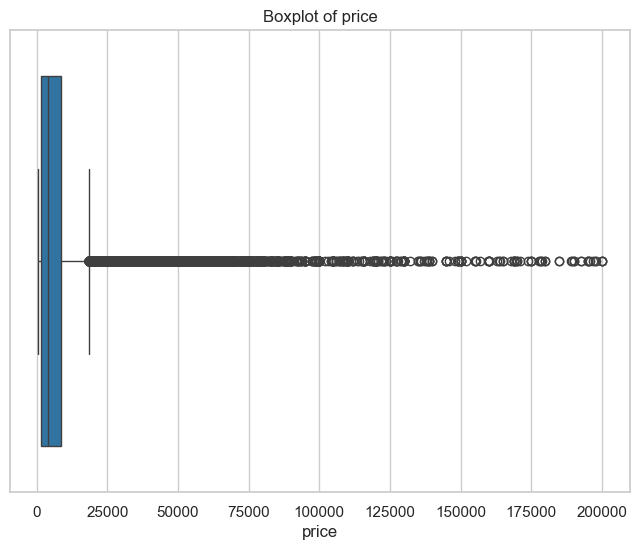

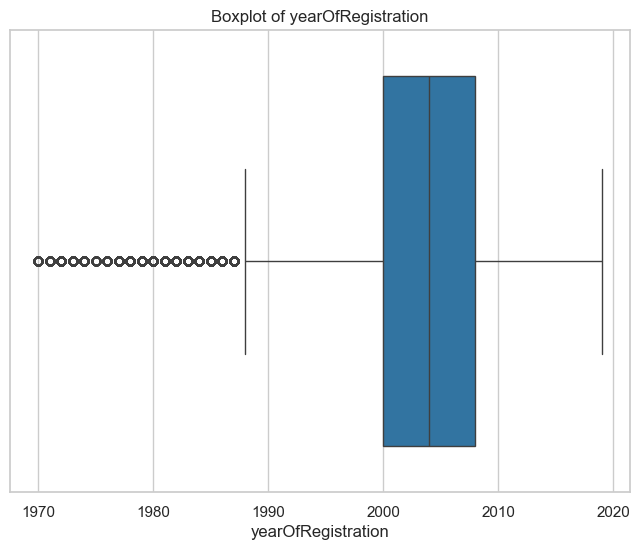

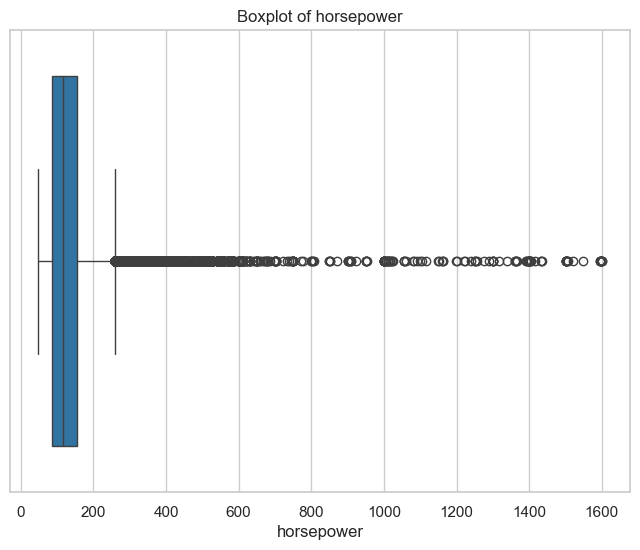

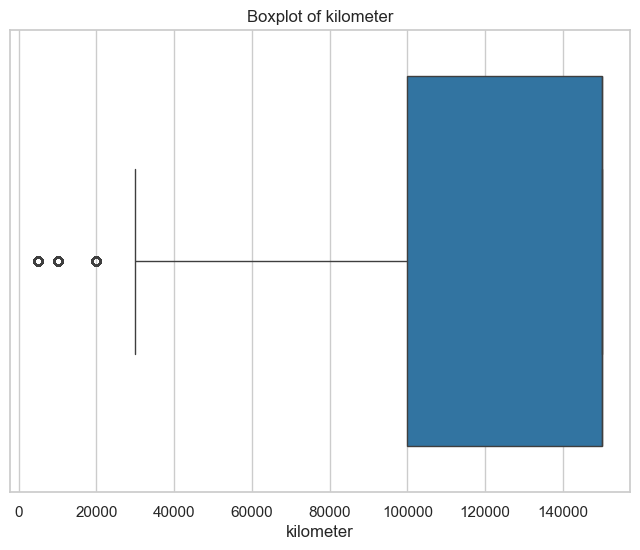

In [104]:
for col in df.columns:
    plt.figure(figsize=(8,6))
    sns.boxplot(
        data = df,
        x = col
        )
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)



Price and horsepower has a lot of outliers.

Take a log transform of the price variable to give it a more normal distribution.


In [105]:
np.exp(2.07944154167)

7.999999999921313

<Axes: xlabel='price_log', ylabel='Count'>

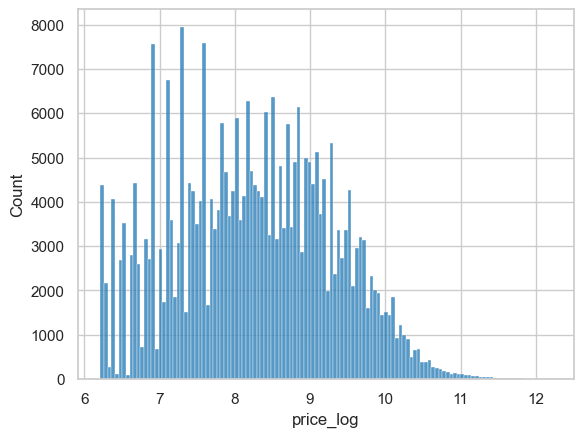

In [106]:
auto_df['price_log'] = np.log(auto_df['price'])
df['price_log'] = np.log(df['price'])

sns.histplot(
    data=df,
    x='price_log'
)

Despite the log transform, the distribution is still very skewed. This will have to be taken into consideration during model building.

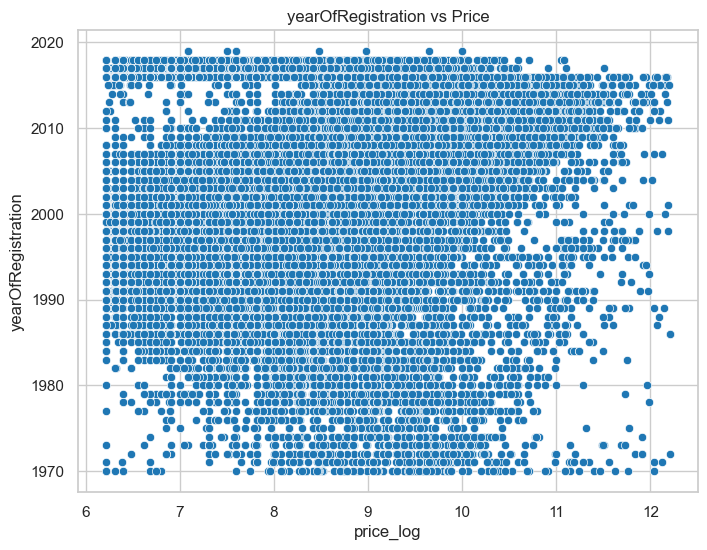

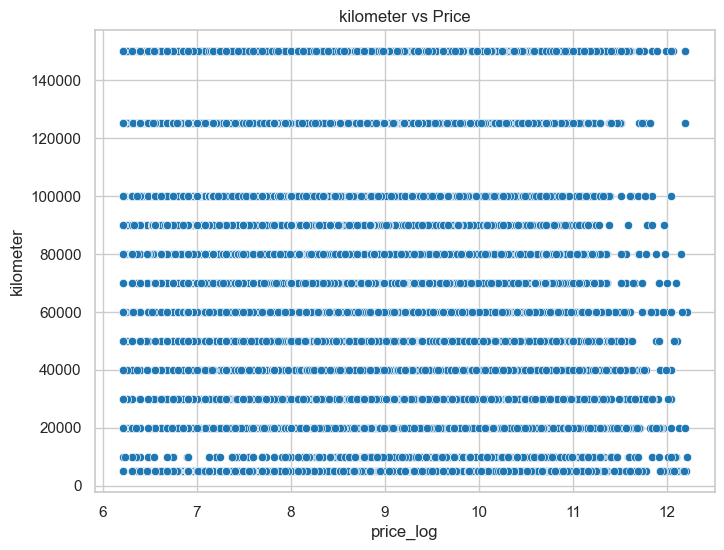

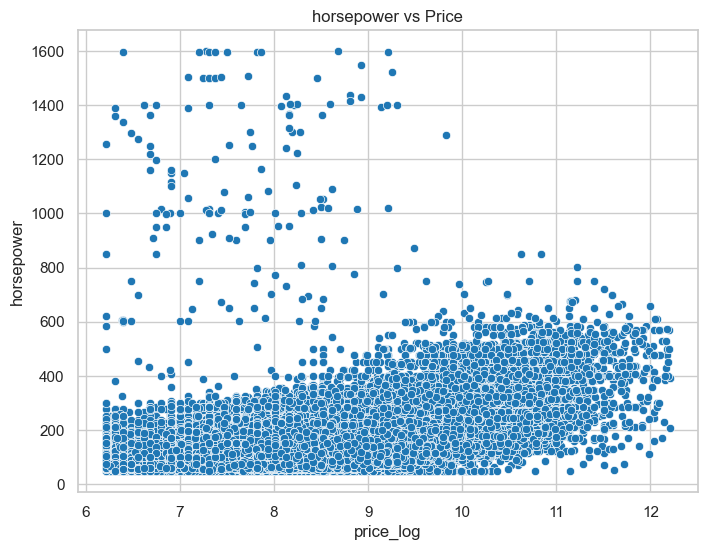

In [107]:
for col in ['yearOfRegistration', 'kilometer', 'horsepower']:
    plt.figure(figsize=(8,6))
    sns.scatterplot(
        data=df,
        y=col,
        x='price_log'
        )
    plt.title(f'{col} vs Price')
    plt.xlabel('price_log')
    plt.ylabel(col)

There doesn't seem to be any visual relationship between Kilometer, horsepower or registration year and price.


In [108]:
def regression_analysis(X_feature, y_feature):
    X_train, X_test, y_train, y_test = train_test_split(X_feature, y_feature, random_state=42, shuffle=True, test_size=0.3)
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    r_squared = lr.score(X_test, y_test)
    print(f'The R_squared score of {col} is {r_squared}')


for col in ['yearOfRegistration', 'kilometer', 'horsepower']:
    regression_analysis(df[['price_log']], df[[col]])

The R_squared score of yearOfRegistration is 0.26138334150486664
The R_squared score of kilometer is 0.19973374577658842
The R_squared score of horsepower is 0.26868284553800426


### Category

In [109]:
df = auto_df.select_dtypes(include='category')
df['price_log'] = auto_df['price_log']
df.drop(columns=['brand'], inplace=True)

['vehicleType', 'gearbox', 'monthOfRegistration', 'fuelType', 'notRepairedDamage']


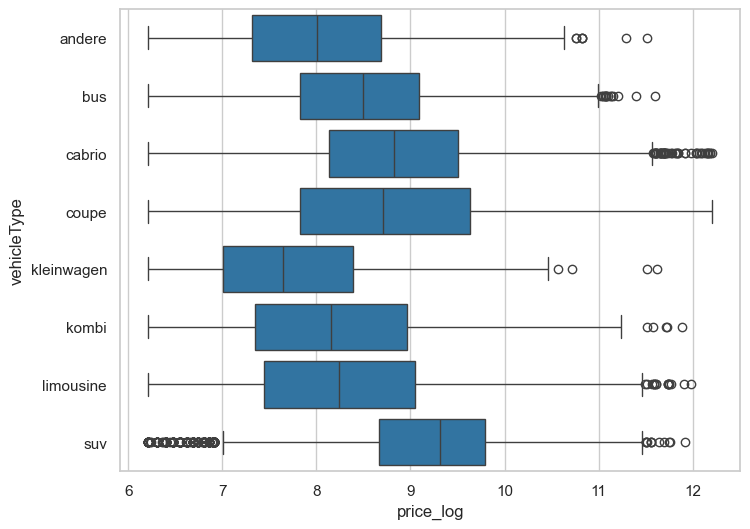

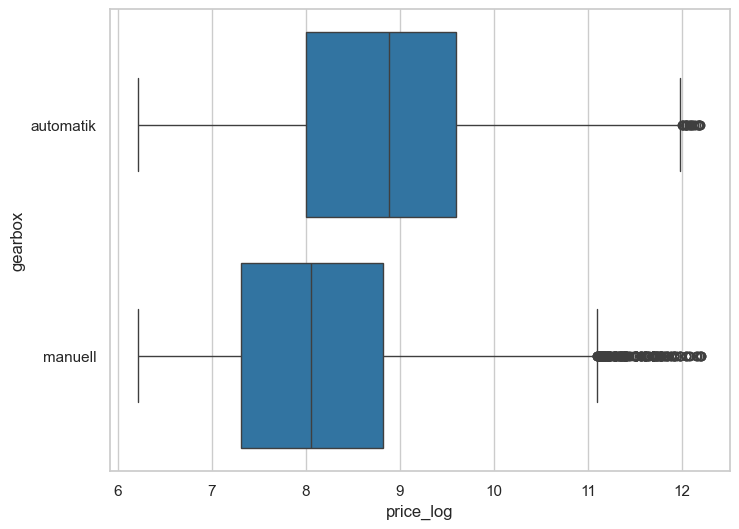

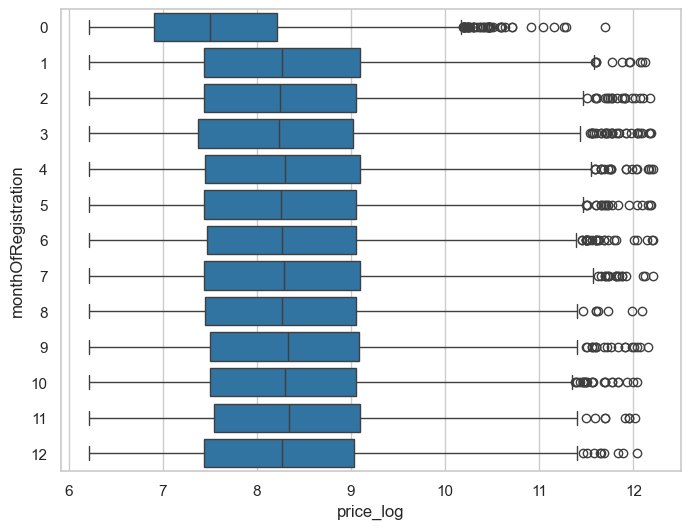

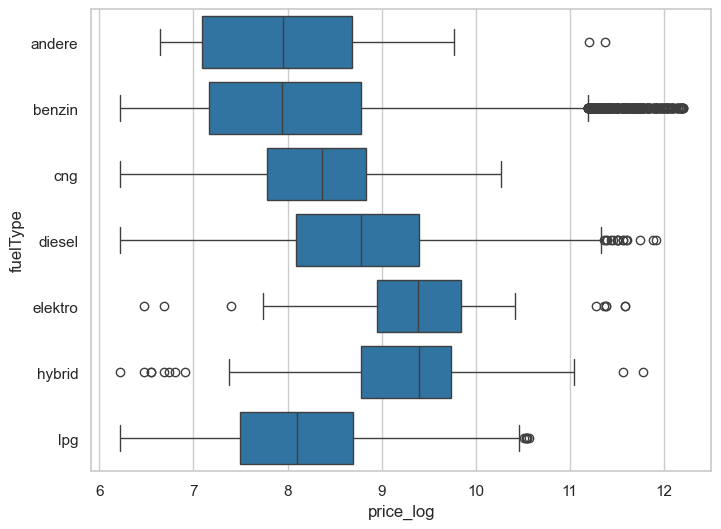

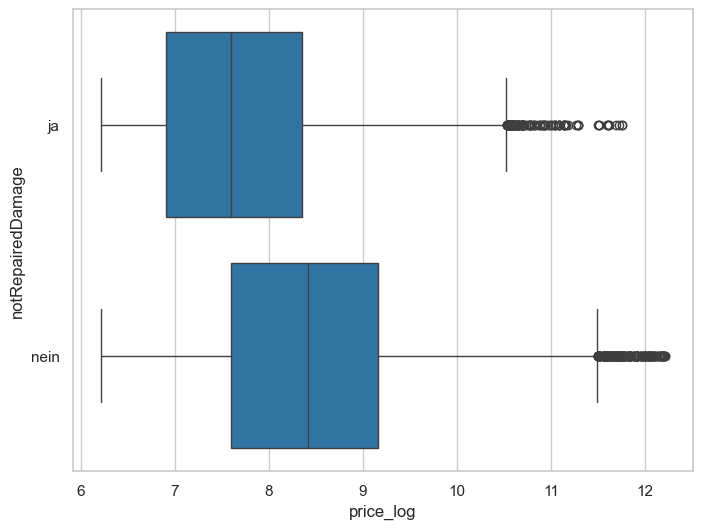

In [110]:
columns = df.columns.to_list()
columns.remove('price_log')
print(columns)
for col in columns:
    plt.figure(figsize=(8,6))
    sns.boxplot(
        data=df,
        x='price_log',
        y=col
        )


1. While the purpose of the abtesting is unknown, the results indicate that therre was no significant difference between the test and control group. (To be tested during hypothesis testing)
2. The remaining variables show a fairly expected distribution.
3. There are 13 groups under month.


In [111]:
auto_df['monthOfRegistration'] = auto_df['monthOfRegistration'].apply(lambda x: np.random.randint(1,13) if x == 0 else x)

### Dates

In [112]:
auto_df['quicklySeen'] = (auto_df['dateCrawled'] - auto_df['dateCreated']).apply(lambda x: x.total_seconds()/(60*60*24))
auto_df['adTimeLength'] = (auto_df['lastSeen'] - auto_df['dateCreated']).apply(lambda x: x.total_seconds()/(60*60*24))
auto_df['yearOfRegistration'] = auto_df['yearOfRegistration'].apply(lambda X: 2023 - X)

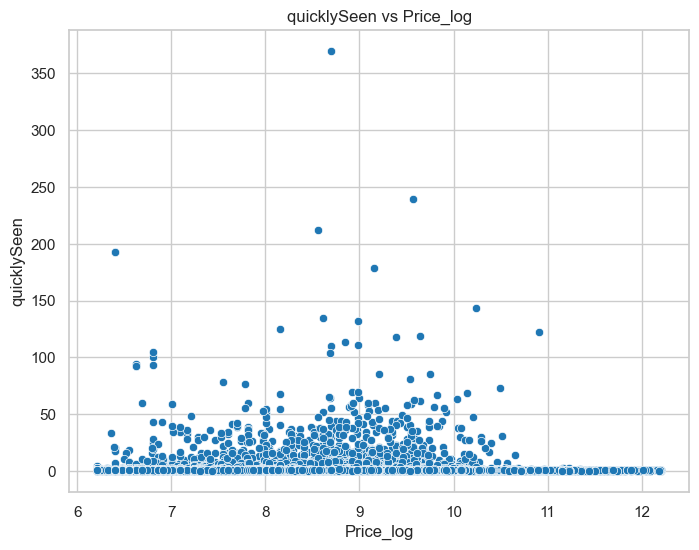

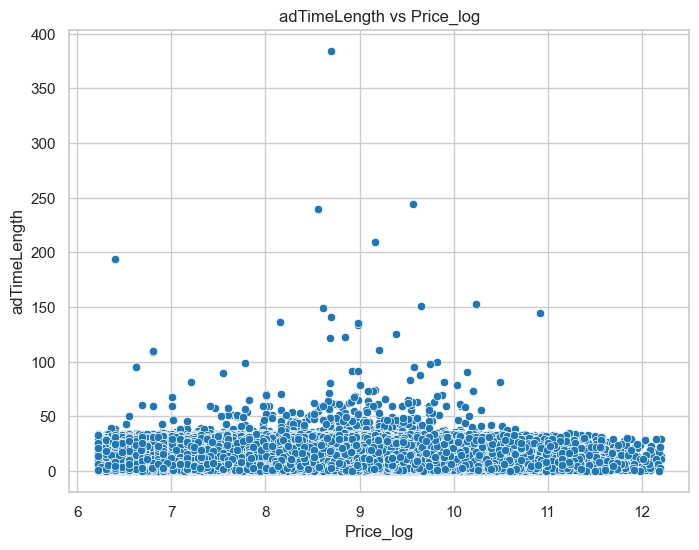

In [113]:
for col in ['quicklySeen', 'adTimeLength']:
    plt.figure(figsize=(8,6))
    sns.scatterplot(
        data = auto_df,
        x = 'price_log',
        y = col
        )
    plt.title(f'{col} vs Price_log')
    plt.ylabel(col)
    plt.xlabel('Price_log')


In [114]:
for col in ['quicklySeen', 'adTimeLength']:
    regression_analysis(auto_df[['price_log']], auto_df[[col]])

The R_squared score of quicklySeen is 1.8250073817505097e-05
The R_squared score of adTimeLength is 0.024985895969637628


## Correlation Analysis

<Axes: >

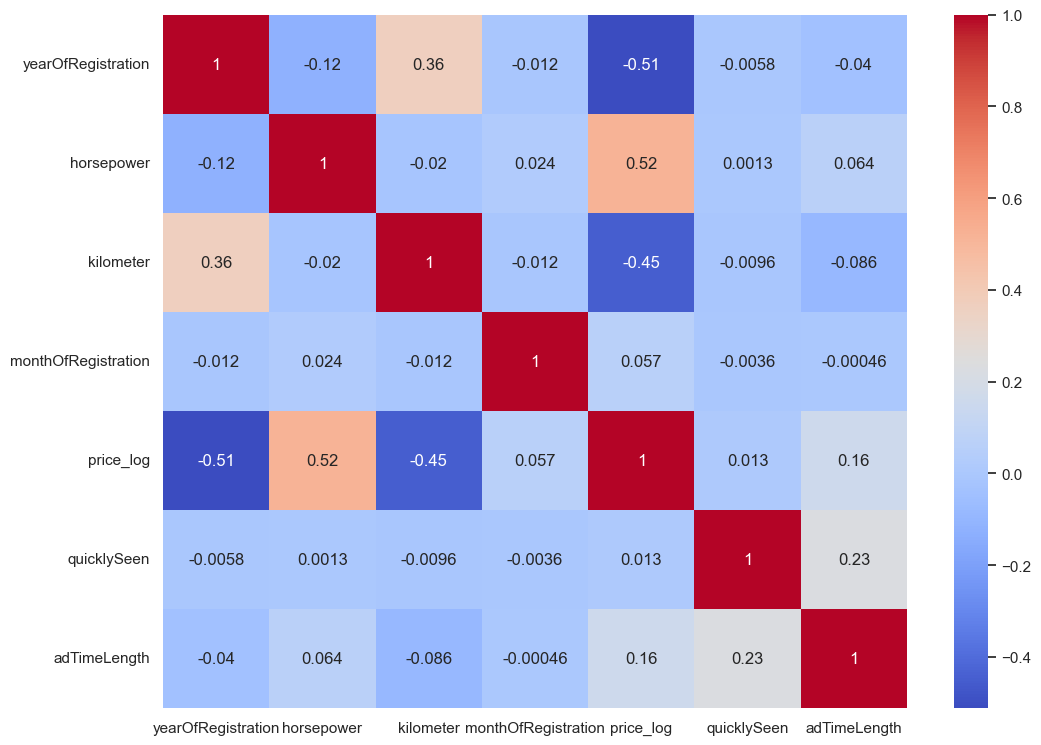

In [115]:
df = auto_df.select_dtypes(include='number')
df.drop(columns=['index', 'postalCode', 'price'], inplace=True)

plt.figure(figsize=(12,9))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

1. price_log has strong corellations with "Year of Registration", "horse power", "Kilometer" and "ad time length".
2. There is also an expected strong corellations between the kilometer and registration year


# Categorical Encoding

In [116]:
# df = auto_df.select_dtypes(include='category')

# for col in df.columns:
#     print(f'{col} column has {df[col].nunique()} unique values')
#     print()


For the columns with two unique values, I'll simply substitue them with 0 and 1.

for the brand column, I'll regroup the data.
 
For the rest, use Scikit-learn category encoding

In [117]:
# I'm creating a new dataframe containing the new columns I've created and removing the discarded columns
model_auto_df = auto_df.copy()
model_auto_df = model_auto_df.drop(columns=['index', 'dateCrawled', 'name', 'seller', 'dateCreated', 'lastSeen', 'price', 'quicklySeen', 'monthOfRegistration'])

In [118]:
# # turning all categorical columns with two unique values into binary columns
# for col in df.columns:
#     if model_auto_df[col].nunique() == 2:
#         choices = list(model_auto_df[col].unique())
#         model_auto_df[col] = model_auto_df[col].map({choices[0]:0, choices[1]:1})

In [119]:
# # for columns with more than 2 unique values
# le = LabelEncoder()
# for col in ['vehicleType', 'fuelType']:
#     le.fit(model_auto_df[col])
#     # print(list(le.classes_))
#     model_auto_df[col] = le.transform(model_auto_df[col])


Brand regrouping

I'll regroup the brand column into three groups based on the average price per group into highend, midrange, budget


In [120]:
# Get the mean price of each group
price_log_by_brand = auto_df.groupby('brand')['price_log'].mean().sort_values()

C:\Users\HP\AppData\Local\Temp\ipykernel_4440\602103732.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_log_by_brand = auto_df.groupby('brand')['price_log'].mean().sort_values()


In [121]:
price_log_by_brand_array = price_log_by_brand.values.reshape(-1, 1)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(price_log_by_brand_array) # clusters the averages into three groups baseed on proximity
cluster_labels = kmeans.labels_

In [122]:
func = np.vectorize(lambda x: 'Budget' if x == 2 else ('Economic' if x == 0 else 'Luxury'))

cluster_labels = func(cluster_labels)
cluster_labels

array(['Budget', 'Budget', 'Budget', 'Budget', 'Budget', 'Budget',
       'Budget', 'Budget', 'Budget', 'Economic', 'Economic', 'Economic',
       'Economic', 'Economic', 'Economic', 'Economic', 'Economic',
       'Economic', 'Economic', 'Economic', 'Economic', 'Economic',
       'Economic', 'Economic', 'Economic', 'Economic', 'Economic',
       'Economic', 'Economic', 'Economic', 'Economic', 'Economic',
       'Luxury', 'Luxury', 'Luxury', 'Luxury', 'Luxury', 'Luxury',
       'Luxury', 'Luxury'], dtype='<U8')

In [123]:
df = pd.DataFrame(price_log_by_brand)
brand_list = df.index.to_list() 
brand_df_dict = {key: value for key, value in zip(brand_list, cluster_labels)}

In [124]:
model_auto_df['brand'] = model_auto_df['brand'].map(brand_df_dict)
model_auto_df.head()

,vehicleType,yearOfRegistration,gearbox,horsepower,model,kilometer,fuelType,brand,notRepairedDamage,postalCode,price_log,adTimeLength
1,coupe,12,manuell,190,fusion,125000,diesel,Luxury,ja,66954,9.814656,14.074190
2,suv,19,automatik,163,grand,125000,diesel,Luxury,ja,90480,9.190138,22.533171
3,kleinwagen,22,manuell,75,golf,150000,benzin,Economic,nein,91074,7.313220,0.736308
4,kleinwagen,15,manuell,69,fabia,90000,diesel,Economic,nein,60437,8.188689,6.428715
5,limousine,28,manuell,102,3er,150000,benzin,Luxury,ja,33775,6.476972,2.803553


# Hypothesis Testing

## Functions

In [125]:
def anderson_darling(df, feature, alpha, target):
  '''
  This function tests for normality in the df.
  
  df: The dataframe that contains the df you want to test.
  feature: The feature being tested for normality.
  target: The column to aggregate.
  alpha: The significance level for the statistical test. Default 0.05 or 5%.                                                   
  alpha should be inserted as a percentage in integer form, eg, 5% should be inserted as 5.
  
  Returns: True or False
  True means that the data follows a normal distribution.
  False means that the data doesn't follows a normal distribution.
  '''
  unique = df[feature].unique()
  counter = []

  for unique_value in unique:
    test_data = df[df[feature]==unique_value][target]
    
    if len(test_data) < 5:
        pass
    
    else:
        result = anderson(test_data)
        test_statistic = result.statistic
        critical_values = list(result.critical_values)
        significance_level = list(result.significance_level)
        index_sig_level = significance_level.index(alpha)

        if test_statistic <= critical_values[index_sig_level]:
            # It follows a normal distribution.
            counter.append(True)
        
        else:
            # It does not follow a normal distribution
            pass
    
  if False in counter:
      return False
  else:
      return True



def anova_assumptions_test(feature, target, df):
    '''
    This function tests the assumptions required for the ANOVA statistical test.

    feature: The feature being tested for ANOVA assumptions.
    target: The column to aggregate for ANOVA.
    df: The dataframe containing the data.

    Returns one of four strings:
    1. The given data passes both tests of homoscedasticity and normality.
    2. The given data passes the test of homoscedasticity but fails the test of normality.
    3. The given data passes the test of normality but fails the test of homoscedasticity.
    4. The given data fails both tests of homoscedasticity and normality.
    '''
    # Homoscedasticity
    feature_std = df.groupby(feature)[target].std()
    max_std = feature_std.max()
    min_std = feature_std.min()

    # Normality
    normality = anderson_darling(df=df, feature=feature, target=target, alpha=5)

    if min_std * 2 >= max_std and normality:
        return 'The given data passes both tests of homoscedasticity and normality.'
    elif min_std * 2 >= max_std and not normality:
        return 'The given data passes the test of homoscedasticity but fails the test of normality.'
    elif min_std * 2 < max_std and normality:
        return 'The given data passes the test of normality but fails the test of homoscedasticity.'
    else:
        return 'The given data fails both tests of homoscedasticity and normality.'
    


def perform_one_way_anova(df, feature, target):
    '''
    Perform a one-way ANOVA test to assess the equality of means among multiple groups.
    
    Parameters:
        df (DataFrame): The DataFrame containing the data.
        feature (str): The column name for the categorical levels.
        target (str): The column name for the continuous variable (CGPA change).

    Returns:
        result (F_onewayResult): The result of the one-way ANOVA test.
    '''
    unique_levels = df[feature].unique()
    levels_data = {level: df[df[feature] == level][target] for level in unique_levels}
    
    result = f_oneway(*levels_data.values())
    
    return (f'ANOVA F-statistic:", {result.statistic}, "ANOVA p-value:", {result.pvalue}')



def perform_pairwise_tukeyhsd(df, feature, target):
    '''
    Perform pairwise Tukey's Honestly Significant Difference (HSD) test to compare group means.

    Parameters:
        df (DataFrame): The DataFrame containing the data.
        feature (str): The column name for the categorical groups.
        target (str): The column name for the data to be compared.

    Returns:
        tukey_result (MultiComparison): The result of the pairwise Tukey's HSD test.
    '''
    tukey_result = pairwise_tukeyhsd(
        endog=df[target],
        groups=df[feature]
    )
    print(tukey_result)


## Hypothesis one

Feature: vehicleType

Null Hypothesis: There is no difference in the average price across different vehicleTypes.

Alternative Hypothesis: There is a difference between the average prices across different vahicleTypes.

Test Type: Two Tailed Test

Proposed Statistical Test: One Way ANOVA Test

Significance level: 0.05

ANOVA Test Assumptions:
1. The samples are independent.
2. Each sample is from a normally distributed population.
3. The population standard deviations of the groups are all equal. This property is known as homoscedasticity.


### Confirming Assumptions

In [126]:
vehicle_anova_assumptions_test = anova_assumptions_test(
    feature= 'vehicleType',
    target= 'price_log',
    df= auto_df
)

print(vehicle_anova_assumptions_test)

C:\Users\HP\AppData\Local\Temp\ipykernel_4440\4013232759.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  feature_std = df.groupby(feature)[target].std()


The given data passes both tests of homoscedasticity and normality.


### Pefroming Anova test


In [127]:
vehicle_anova_test = perform_one_way_anova(
    feature= 'vehicleType',
    target= 'price_log',
    df= auto_df
)

print(vehicle_anova_test)

ANOVA F-statistic:", 5919.854220898323, "ANOVA p-value:", 0.0


 f-statistic value of 5953 with a p-value of 0 and an alpha of 0.05 means that that we can reject the null hypothesis and that there is a large inter-group variance. This f-statistics supports the p-value.

### Post-Hoc Analysis

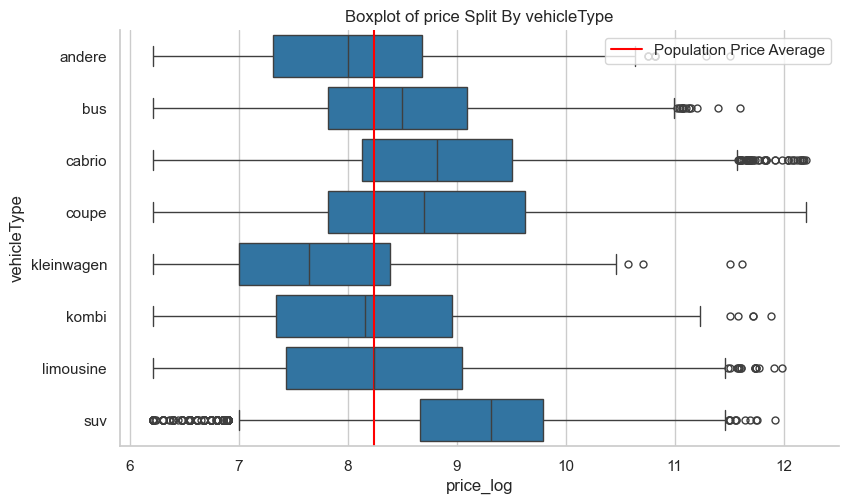

In [128]:
# Visualizing the difference
sns.catplot(
    kind='box',
    data=auto_df,
    x='price_log',
    y='vehicleType',
    aspect=12/7
)
plt.axvline(auto_df.price_log.mean(),color='red',label='Population Price Average')  
plt.legend(loc='upper right')                                                                           
plt.title('Boxplot of price Split By vehicleType');

In [129]:
# Investigating pairwise differences                                                                                 
vehicle_tukey_results = perform_pairwise_tukeyhsd(
    feature= 'vehicleType',
    target= 'price_log',
    df= auto_df
)
vehicle_tukey_results

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1     group2   meandiff p-adj  lower   upper  reject
-----------------------------------------------------------
    andere        bus   0.4412   0.0  0.3747  0.5078   True
    andere     cabrio   0.7814   0.0  0.7141  0.8488   True
    andere      coupe   0.6915   0.0  0.6233  0.7597   True
    andere kleinwagen  -0.2996   0.0 -0.3647 -0.2344   True
    andere      kombi   0.1452   0.0  0.0802  0.2101   True
    andere  limousine   0.2272   0.0  0.1623   0.292   True
    andere        suv   1.1797   0.0  1.1107  1.2488   True
       bus     cabrio   0.3402   0.0  0.3125  0.3679   True
       bus      coupe   0.2502   0.0  0.2205  0.2799   True
       bus kleinwagen  -0.7408   0.0 -0.7627 -0.7189   True
       bus      kombi  -0.2961   0.0 -0.3173 -0.2749   True
       bus  limousine  -0.2141   0.0  -0.235 -0.1931   True
       bus        suv   0.7385   0.0  0.7068  0.7701   True
    cabrio      coupe    -0.09   0.0 -0.

Post-Hoc Analysis confirms that significant difference exist across all vehicle types

## Hypothesis two

Feature: gearbox

Null Hypothesis:  There is no difference in price between automatic and manual cars.

Alternative Hypothesis: The price of automatic cars is not equal to the price of manual cars.

Test Type: Two Tailed Test

Proposed Statistical Test: One Way ANOVA Test

Significance level: 0.05

ANOVA Test Assumptions:
1. The samples are independent.
2. Each sample is from a normally distributed population.
3. The population standard deviations of the groups are all equal. This property is known as homoscedasticity.


### Confirming Assumptions

In [130]:
gearbox_anova_assumptions_test = anova_assumptions_test(
    feature= 'gearbox',
    target= 'price_log',
    df= auto_df
)

print(gearbox_anova_assumptions_test)

C:\Users\HP\AppData\Local\Temp\ipykernel_4440\4013232759.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  feature_std = df.groupby(feature)[target].std()


The given data passes both tests of homoscedasticity and normality.


### Performing Anova Test

In [131]:
gearbox_anova_test = perform_one_way_anova(
    feature= 'gearbox',
    target= 'price_log',
    df= auto_df
)

print(gearbox_anova_test)

ANOVA F-statistic:", 27270.02983680151, "ANOVA p-value:", 0.0


 f-statistic value of 27173 with a p-value of 0 and an alpha of 0.05 means that that we can reject the null hypothesis and that there is a large inter-group variance. This f-statistics supports the p-value.

### Post-HOC Analysis

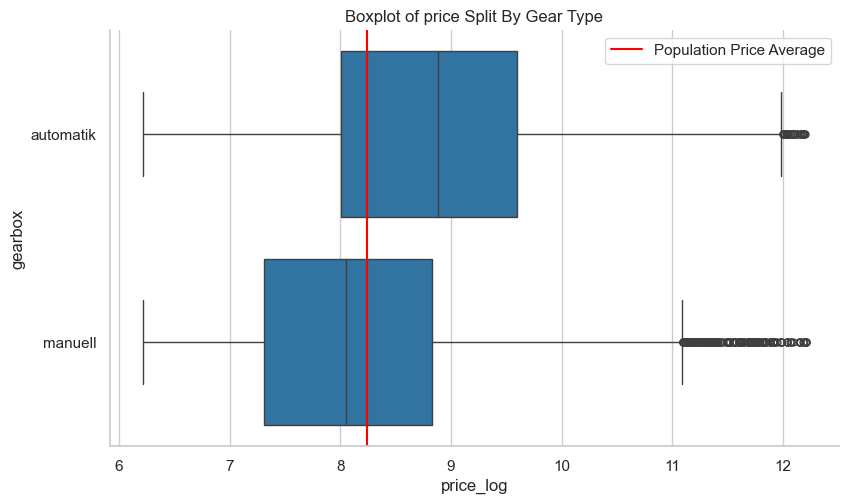

In [132]:
# Visualizing the difference
sns.catplot(
    kind='box',
    data=auto_df,
    x='price_log',
    y='gearbox',
    aspect=12/7
)
plt.axvline(auto_df.price_log.mean(),color='red',label='Population Price Average')  
plt.legend(loc='upper right')                                                                           
plt.title('Boxplot of price Split By Gear Type');

Automatic cars are more expensive than manual cars.

## Hypothesis Three

Feature: fuelType

Null Hypothesis: There is no difference in the average price across different fuelTypes.

Alternative Hypothesis: There is a difference between the average prices across different fuelTypes.

Test Type: Two Tailed Test

Proposed Statistical Test: One Way ANOVA Test

Significance level: 0.05

ANOVA Test Assumptions:
1. The samples are independent.
2. Each sample is from a normally distributed population.
3. The population standard deviations of the groups are all equal. This property is known as homoscedasticity.


### Confirming Assumptions

In [133]:
fuel_anova_assumptions_test = anova_assumptions_test(
    feature= 'fuelType',
    target= 'price_log',
    df= auto_df
)

print(fuel_anova_assumptions_test)

The given data passes both tests of homoscedasticity and normality.


C:\Users\HP\AppData\Local\Temp\ipykernel_4440\4013232759.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  feature_std = df.groupby(feature)[target].std()


### Performing Anova Test

In [134]:
fueltype_anova_test = perform_one_way_anova(
    feature= 'fuelType',
    target= 'price_log',
    df= auto_df
)

print(fueltype_anova_test)

ANOVA F-statistic:", 5566.562910366635, "ANOVA p-value:", 0.0


 f-statistic value of 5617 with a p-value of 0 and an alpha of 0.05 means that that we can reject the null hypothesis and that there is a large inter-group variance. This f-statistics supports the p-value.

### Post-HOC Analysis

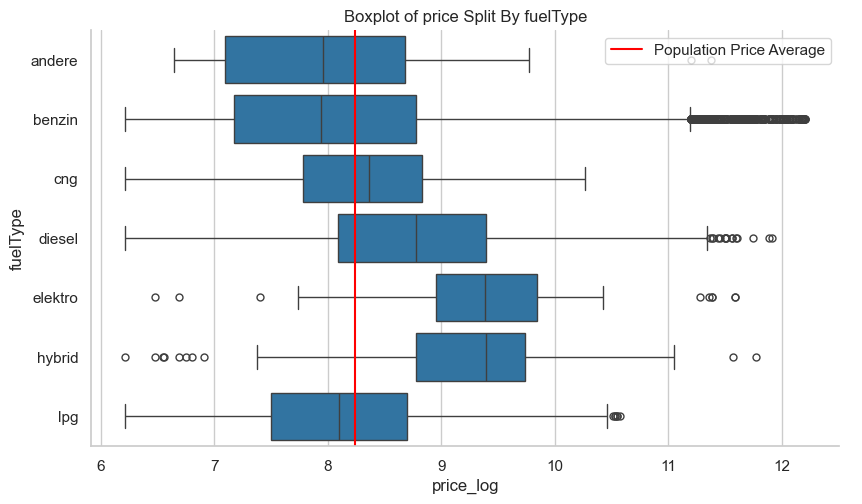

In [135]:
# Visualizing the difference
sns.catplot(
    kind='box',
    data=auto_df,
    x='price_log',
    y='fuelType',
    aspect=12/7
)
plt.axvline(auto_df.price_log.mean(),color='red',label='Population Price Average')  
plt.legend(loc='upper right')                                                                           
plt.title('Boxplot of price Split By fuelType');

In [136]:
# Investigating pairwise differences                                                                                 
vehicle_tukey_results = perform_pairwise_tukeyhsd(
    feature= 'fuelType',
    target= 'price_log',
    df= auto_df
)
vehicle_tukey_results

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
 andere  benzin  -0.0634 0.9994 -0.4771  0.3503  False
 andere     cng   0.2101 0.7884 -0.2246  0.6449  False
 andere  diesel   0.6504 0.0001  0.2366  1.0642   True
 andere elektro   1.3098    0.0  0.7056   1.914   True
 andere  hybrid   1.2065    0.0  0.7518  1.6612   True
 andere     lpg   0.0253    1.0 -0.3906  0.4412  False
 benzin     cng   0.2736    0.0  0.1395  0.4076   True
 benzin  diesel   0.7138    0.0  0.7022  0.7254   True
 benzin elektro   1.3732    0.0  0.9328  1.8137   True
 benzin  hybrid   1.2699    0.0  1.0811  1.4588   True
 benzin     lpg   0.0887    0.0  0.0453  0.1321   True
    cng  diesel   0.4402    0.0   0.306  0.5744   True
    cng elektro   1.0997    0.0  0.6394    1.56   True
    cng  hybrid   0.9964    0.0   0.765  1.2277   True
    cng     lpg  -0.1848  0.002 -0.3254 -0.0443   True
 diesel el

Andere is german for other. There are insignificant differences between unclassified/unknown/untraditional fueltypes and vehicles using gas (Compressed Natural Gas, cng and Liquefied Natural Gas, lng) and petrol (benzin).

# Model Selection

## Building Baseline model

In [137]:
# model_auto_df.head()

In [138]:
# X = model_auto_df.drop(columns=['price_log', 'model'])
# y = model_auto_df.price_log

# X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42, test_size=0.3)

# baseline_model = LinearRegression()

In [139]:
# baseline_model.fit(X_train, y_train)

# y_pred = baseline_model.predict(X_test)

# print(baseline_model.score(X_test, y_test))

In [140]:
# print(mean_squared_error(y_pred=y_pred, y_true=y_test))

Baseline model has a r_squared value of 0.63 and a mean squared error of 0.42

## Model Selection

In [141]:
# def test_model(model, X, y):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42, test_size=0.3)
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)

#     print(model)
#     print(f'r_squared: {model.score(X_test, y_test)}')
#     print(f'mse: {mean_squared_error(y_pred=y_pred, y_true=y_test)}')
#     print(f'mae: {mean_absolute_error(y_pred=y_pred, y_true=y_test)}')


In [142]:
# svr = SVR()
# rf = RandomForestRegressor()
# lgb = LGBMRegressor()

# X = model_auto_df.drop(columns=['price_log', 'model'])
# y = model_auto_df.price_log

In [143]:
# test_model(svr, X, y)
# This is shit.

In [144]:
# test_model(lgb, X, y)

In [145]:
# test_model(rf, X, y)

# Model Building

While random forest has a better performance than LGB however due to the time it takes to train the model, LGB will work better for feature selection and hyperparameter tuning.

## Feature Selection

In [146]:
# model_auto_df.head()

In [147]:
# X = model_auto_df.drop(columns=['price_log', 'model', 'postalCode'])
# y = model_auto_df.price_log

In [148]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42, test_size=0.3)

In [149]:
# lgb_model = LGBMRegressor()

In [150]:
# lgb_model.fit(X_train, y_train)
# y_pred = lgb_model.predict(X_test)
# print(f'Full features r_squared score: {lgb_model.score(X_test, y_test)}')
# print(f'Full features mse: {mean_squared_error(y_pred, y_test)}')
# print(f'Full features mae: {mean_absolute_error(y_pred, y_test)}')

In [151]:
# x = lgb_model.feature_importances_

# df = pd.DataFrame(
#     {
#         'features': list(X.columns),
#         'importance': x
#     }
# )

# df = df.sort_values('importance',ascending=False)
# df

In [152]:
# r2_score = []
# mse = []
# mae = []
# dropped_feature = []

In [153]:
# for num in range(5):
#     dropped_feature.append(df.iloc[-1, 0])
    
#     X = X.drop(columns=[df.iloc[-1, 0]])
#     y = model_auto_df.price_log
    
#     X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42, test_size=0.3)
    
#     lgb_model = LGBMRegressor()

#     lgb_model.fit(X_train, y_train)
#     y_pred = lgb_model.predict(X_test)

#     r2_score.append(lgb_model.score(X_test, y_test))
#     mse.append(mean_squared_error(y_pred, y_test))
#     mae.append(mean_absolute_error(y_pred, y_test))

#     feature_score = lgb_model.feature_importances_
    
#     df = pd.DataFrame(
#         {
#             'features': list(X.columns),
#             'importance': feature_score
#         }
#             )
    
#     df = df.sort_values('importance',ascending=False)

In [154]:
# r2_score

In [155]:
# mse

In [156]:
# mae

In [157]:
# dropped_feature

Dropping features had no positive effect on the model performance.

## Hyperparameter Tuning

In [158]:
model_df = model_auto_df.drop(columns=['model', 'postalCode'])
# Updating the model
model_df.to_csv('model_dataset.csv')

In [159]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 8],
    'num_leaves': [20, 50, 100],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

In [160]:
lgb_model = LGBMRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error'
)

In [161]:
vehicle_map = {key: i for i, key in enumerate(model_df['vehicleType'].unique())}
vehicle_map['other'] = 8
gearbox_map = {key: i for i, key in enumerate(model_df['gearbox'].unique())}
fueltype_map = {key: i for i, key in enumerate(model_df['fuelType'].unique())}
fueltype_map['other'] = 7
damaged_map = {key: i for i, key in enumerate(model_df['notRepairedDamage'].unique())}
brand_map = {key: i for i, key in enumerate(model_df['brand'].unique())}

In [162]:
model_df['vehicleType'] =model_df['vehicleType'].map(vehicle_map)
model_df['gearbox'] =model_df['gearbox'].map(gearbox_map)
model_df['fuelType'] =model_df['fuelType'].map(fueltype_map)
model_df['notRepairedDamage'] =model_df['notRepairedDamage'].map(damaged_map)
model_df['brand'] =model_df['brand'].map(brand_map)

In [163]:
model_df

,vehicleType,yearOfRegistration,gearbox,horsepower,kilometer,fuelType,brand,notRepairedDamage,price_log,adTimeLength
1,0,12,0,190,125000,0,0,0,9.814656,14.074190
2,1,19,1,163,125000,0,0,0,9.190138,22.533171
3,2,22,0,75,150000,1,1,1,7.313220,0.736308
4,2,15,0,69,90000,0,1,1,8.188689,6.428715
5,3,28,0,102,150000,1,0,0,6.476972,2.803553
...,...,...,...,...,...,...,...,...,...,...
371520,3,19,0,225,150000,1,1,0,8.070906,0.864387
371524,4,23,1,101,125000,1,1,1,7.089243,6.761944
371525,5,27,0,102,150000,0,1,1,9.126959,19.302384
371526,6,21,0,100,150000,0,1,0,8.131531,4.531493


In [164]:
X = model_df.drop(columns=['price_log'])
y = model_df.price_log

In [165]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [166]:
# grid_search.fit(X_train, y_train)

# print(f'Best parameters: {grid_search.best_params_}')

Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 200, 'num_leaves': 100, 'subsample': 0.6}

# Additions

In [169]:
auto_df

,index,dateCrawled,name,seller,price,vehicleType,yearOfRegistration,gearbox,horsepower,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,postalCode,lastSeen,price_log,quicklySeen,adTimeLength
1,1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,18300,coupe,12,manuell,190,fusion,125000,5,diesel,audi,ja,2016-03-24,66954,2016-04-07 01:46:50,9.814656,0.457465,14.074190
2,2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,9800,suv,19,automatik,163,grand,125000,8,diesel,jeep,ja,2016-03-14,90480,2016-04-05 12:47:46,9.190138,0.536354,22.533171
3,3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,1500,kleinwagen,22,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17,91074,2016-03-17 17:40:17,7.313220,0.704213,0.736308
4,4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,3600,kleinwagen,15,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31,60437,2016-04-06 10:17:21,8.188689,0.725926,6.428715
5,5,2016-04-04 17:36:23,BMW_316i___e36_Limousine___Bastlerfahrzeug__Ex...,privat,650,limousine,28,manuell,102,3er,150000,10,benzin,bmw,ja,2016-04-04,33775,2016-04-06 19:17:07,6.476972,0.733600,2.803553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371520,371520,2016-03-19 19:53:49,turbo_defekt,privat,3200,limousine,19,manuell,225,leon,150000,5,benzin,seat,ja,2016-03-19,96465,2016-03-19 20:44:43,8.070906,0.829039,0.864387
371524,371524,2016-03-05 19:56:21,Smart_smart_leistungssteigerung_100ps,privat,1199,cabrio,23,automatik,101,fortwo,125000,3,benzin,smart,nein,2016-03-05,26135,2016-03-11 18:17:12,7.089243,0.830799,6.761944
371525,371525,2016-03-19 18:57:12,Volkswagen_Multivan_T4_TDI_7DC_UY2,privat,9200,bus,27,manuell,102,transporter,150000,3,diesel,volkswagen,nein,2016-03-19,87439,2016-04-07 07:15:26,9.126959,0.789722,19.302384
371526,371526,2016-03-20 19:41:08,VW_Golf_Kombi_1_9l_TDI,privat,3400,kombi,21,manuell,100,golf,150000,6,diesel,volkswagen,ja,2016-03-20,40764,2016-03-24 12:45:21,8.131531,0.820231,4.531493
